In [1]:
from utils import MLP, base_cost, get_episode, policy_objective, baseline_objective, sample_action, transform_action, systems, process_system, action_logprob, get_episode_cost
from jax import jit
from functools import partial
from tqdm.auto import tqdm
from datetime import timedelta as td, datetime as dt

import jax.numpy as jnp
import optax
import jax
import matplotlib.pyplot as plt

In [2]:
key = jax.random.PRNGKey(1)

In [3]:
sys_name = "LP"
system_info=systems[sys_name]
# target=dict(YD_r=1.2, C=0.8)
target=dict(YD_r=2.5)

In [4]:
parameters = dict(
    policy_hidden_dims=[],
    policy_seed=jnp.array([123, 123], dtype="u4"),
    policy_lr=5e-1,
    seed=jnp.array([124, 123], dtype="u4"),
    n_steps=64,
    eval_seed=jnp.array([101, 101], dtype="u4"),
    eval_n_episodes=256,
    eval_freq=32,
    train_n_episodes=1024,
)

In [5]:
system_data = process_system(system_info)
update = system_data["update"]

state_dim = len(system_data["state_vars"])
action_dim = len(system_data["action_vars"])
system_params = jnp.array([system_info["params"][k] for k in system_data["params"]])

In [6]:
initial_state_stub = system_info["initial_state_stub"] if "initial_state_stub" in system_info else lambda x: x

In [7]:
var_idx = jnp.array([system_data["state_vars"].index(v) for v in target.keys()])
var_targ = jnp.array(list(target.values()))
cost = jit(partial(base_cost, i=var_idx, t=var_targ))

In [8]:
policy_model = MLP(dims=[*parameters["policy_hidden_dims"], action_dim])
policy_params = policy_model.init(parameters["policy_seed"], jnp.empty(state_dim))

In [9]:
get_raw_action = jit(policy_model.apply)
policy_opt = optax.adam(learning_rate=parameters["policy_lr"])
policy_opt_state = policy_opt.init(policy_params)

action_transforms = tuple(system_info["actions"][act]["transform"] for act in system_data["action_vars"])
action_postprocess = tuple(system_info["actions"][act]["postprocess"] for act in system_data["action_vars"])

obj_val_and_grad = jax.value_and_grad(get_episode_cost)

In [10]:
# initial_states = initial_state_stub(jax.random.uniform(key, (parameters["train_n_episodes"], state_dim)))
n_episodes = 1
eval_states = initial_state_stub(jax.random.uniform(parameters["seed"], (1, state_dim)))
initial_states = jnp.repeat(eval_states, n_episodes, axis=0)

  0%|          | 0/100 [00:00<?, ?it/s]

10: cost 1.764921
20: cost 1.763117
30: cost 1.761441
40: cost 1.759878
50: cost 1.758419
60: cost 1.757051
70: cost 1.755797
80: cost 1.754622
90: cost 1.753511
100: cost 1.752455


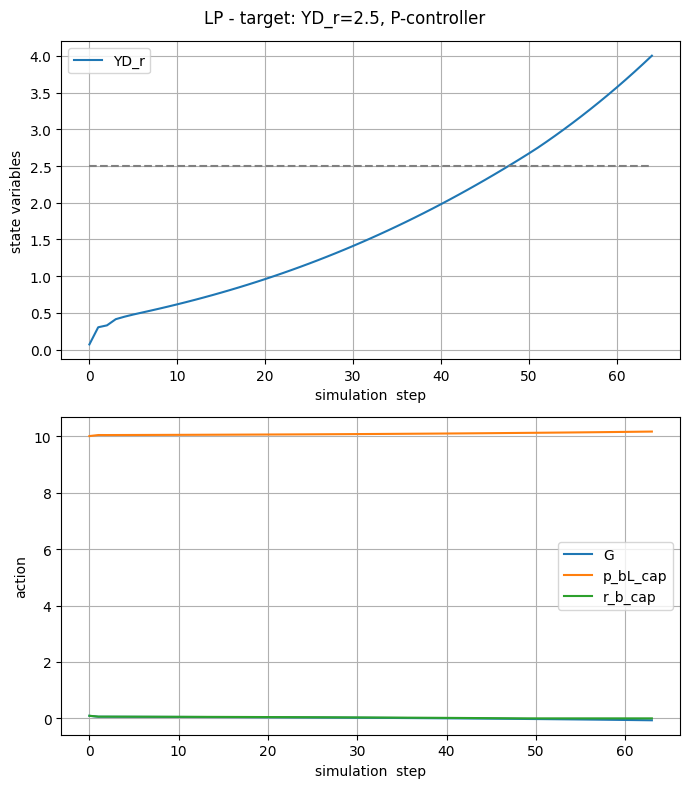

In [16]:
n_epochs = 100

n_steps = parameters["n_steps"]

get_action = lambda params, state: transform_action(get_raw_action(params, state), action_transforms)
action_sampler = lambda params, state, key: sample_action(get_action(params, state), sigma, key, action_postprocess)
get_action = lambda params, state: transform_action(get_raw_action(params, state), action_transforms)

for i in tqdm(range(n_epochs)):
    key, seed = jax.random.split(key)
    val, grad = obj_val_and_grad(policy_params, update, system_params, get_action, initial_states, cost, n_steps, seed)
    updates, policy_opt_state = policy_opt.update(grad, policy_opt_state)
    policy_params = optax.apply_updates(policy_params, updates)

    if (i+1) % 10 == 0:
        # last_eval_time = cur_time
        eval_cost = get_episode_cost(policy_params, update, system_params, get_action, eval_states, cost, parameters["n_steps"], parameters["eval_seed"])
        print(f"{i+1}: cost {eval_cost:.6f}")

action_sampler = lambda params, state, key: sample_action(get_action(params, state), 0.0, key, action_postprocess)
states, actions = get_episode(update, system_params, action_sampler, policy_params, eval_states, n_steps, seed)

fig, ax = plt.subplots(nrows=2, figsize=(7, 8), tight_layout=True)

target_str = " ".join(map(lambda kv: f"{kv[0]}={kv[1]}", target.items()))
fig.suptitle(f"{sys_name} - target: {target_str}, P-controller")

label = list(target.keys())
ax[0].plot(states[0,:,var_idx].T, label=label if len(label) > 1 else label[0])
ax[0].hlines(target.values(), xmin=0, xmax=n_steps, color='grey', linestyles='--')
ax[0].set_xlabel("simulation  step")
ax[0].set_ylabel("state variables")
ax[0].legend()
ax[0].grid()

# ax[1].set_title(f"test_sample_{sample_idx[0]} action")
ax[1].plot(actions[0], label=system_data["action_vars"])
ax[1].set_xlabel("simulation  step")
ax[1].set_ylabel("action")
ax[1].legend()
ax[1].grid()

In [17]:
fig.savefig("lp_ydr25_p_cont.png")